## About this notebook

This notebook contains experiment results from the paper, [Deep Multi-Task Learning for SSVEP Detection and Visual Response Mapping](https://jinglescode.github.io/ssvep-multi-task-learning/). Using multi-task learning to capture signals simultaneously from the fovea efficiently and the neighboring targets in the peripheral vision generate a visual response map. A calibration-free user-independent solution, desirable for clinical diagnostics. A stepping stone for an objective assessment of glaucoma patients’ visual field.

![figures-main-idea-big](https://user-images.githubusercontent.com/1694368/91680983-9caa4580-eb7f-11ea-8bfd-50e0705c141d.jpg)

## torchsignal

This notebook uses [torchsignal](https://github.com/jinglescode/torchsignal), a package for common signal processing tasks for PyTorch. Use Git or checkout with SVN, and install the dependencies:

```
git clone https://github.com/jinglescode/torchsignal.git
pip install -r requirements.txt
```

## Dataset

We used an open-access dataset by Tsinghua University, HS-SSVEP, a 40-classes dataset for visual spelling tasks.
This dataset is by Yijun Wang, Xiaogang Chen, Xiaorong Gao, Shangkai Gao

[[Paper]((https://ieeexplore.ieee.org/document/7740878))] [[Dataset website](http://bci.med.tsinghua.edu.cn/download.html)]
    

### Init and Config

In [1]:
%cd ../torchsignal

D:\workspace\github\torchsignal


In [2]:
from torchsignal.datasets.hsssvep import HSSSVEP
from torchsignal.datasets.multiplesubjects import MultipleSubjects
from torchsignal.trainer.multitask import Multitask_Trainer

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
config = {
  "exp_name": "model",
  "seed": 12,
  "segment_config": {
    "window_len": 4,
    "shift_len": 250,
    "sample_rate": 250,
    "add_segment_axis": True
  },
  "bandpass_config": {
      "sample_rate": 250,
      "lowcut": 1,
      "highcut": 40,
      "order": 6
  },
  "train_subject_ids": {
    "low": 1,
    "high": 35
  },
  "test_subject_ids": {
    "low": 1,
    "high": 35
  },
  "root": "../data/hsssvep",
  "selected_channels": ['PZ', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2', 'PO7', 'PO8'],
  "num_classes": 40,
  "num_channel": 11,
  "batchsize": 64,
  "learning_rate": 0.001,
  "epochs": 100,
  "patience": 5,
  "early_stopping": 10,
  "model": {
    "n1": 4,
    "kernel_window_ssvep": 59,
    "kernel_window": 19,
    "conv_3_dilation": 4,
    "conv_4_dilation": 4
  },
  "gpu": 0,
  "multitask": True,
  "runkfold": 3,
}

device = torch.device("cuda:"+str(config['gpu']) if torch.cuda.is_available() else "cpu")
print('device', device)

device cuda:0


### Load Subjects Data

In [4]:
subject_ids = list(np.arange(config['train_subject_ids']['low'], config['train_subject_ids']['high']+1, dtype=int))

data = MultipleSubjects(
    dataset=HSSSVEP, 
    root=config['root'], 
    subject_ids=subject_ids, 
    selected_channels=config['selected_channels'],
    segment_config=config['segment_config'],
    bandpass_config=config['bandpass_config'],
    one_hot_labels=True,
)

Load subject: 1
Load subject: 2
Load subject: 3
Load subject: 4
Load subject: 5
Load subject: 6
Load subject: 7
Load subject: 8
Load subject: 9
Load subject: 10
Load subject: 11
Load subject: 12
Load subject: 13
Load subject: 14
Load subject: 15
Load subject: 16
Load subject: 17
Load subject: 18
Load subject: 19
Load subject: 20
Load subject: 21
Load subject: 22
Load subject: 23
Load subject: 24
Load subject: 25
Load subject: 26
Load subject: 27
Load subject: 28
Load subject: 29
Load subject: 30
Load subject: 31
Load subject: 32
Load subject: 33
Load subject: 34
Load subject: 35


In [5]:
print("Input data shape:", data.data_by_subjects[1].data.shape)
print("Target shape:", data.data_by_subjects[1].targets.shape)

Input data shape: (240, 11, 1000)
Target shape: (240,)


### Multi-task Learning Model

![figures-model](https://user-images.githubusercontent.com/1694368/91679200-2ce58c00-eb7a-11ea-82a3-1df6ef6aee24.png)

![figures-mtl-module](https://user-images.githubusercontent.com/1694368/91679765-cb262180-eb7b-11ea-9417-64af2d3f0292.png)

In [6]:
class Multitask_Model(nn.Module):
    def __init__(self, num_channel=10, num_classes=4, signal_length=1000, filters_n1=4, kernel_window_ssvep=59, kernel_window=19, conv_3_dilation=4, conv_4_dilation=4):
        super().__init__()

        filters = [filters_n1, filters_n1 * 2]

        self.conv_1 = conv_block(in_ch=1, out_ch=filters[0], kernel_size=(1, kernel_window_ssvep), w_in=signal_length)
        self.conv_2 = conv_block(in_ch=filters[0], out_ch=filters[0], kernel_size=(num_channel, 1))
        self.conv_3 = conv_block(in_ch=filters[0], out_ch=filters[1], kernel_size=(1, kernel_window), padding=(0,conv_3_dilation-1), dilation=(1,conv_3_dilation), w_in=self.conv_1.w_out)
        self.conv_4 = conv_block(in_ch=filters[1], out_ch=filters[1], kernel_size=(1, kernel_window), padding=(0,conv_4_dilation-1), dilation=(1,conv_4_dilation), w_in=self.conv_3.w_out)
        self.conv_mtl = multitask_block(filters[1]*num_classes, num_classes, kernel_size=(1, self.conv_4.w_out))
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.unsqueeze(x,1)

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.dropout(x)

        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.dropout(x)

        x = self.conv_mtl(x)

        return x


class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding=(0,0), dilation=(1,1), groups=1, w_in=None):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, dilation=dilation, groups=groups),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True)
        )

        if w_in is not None:
            self.w_out = int( ((w_in + 2 * padding[1] - dilation[1] * (kernel_size[1]-1)-1) / 1) + 1 )

    def forward(self, x):
        return self.conv(x)

    
class multitask_block(nn.Module):
    def __init__(self, in_ch, num_classes, kernel_size):
        super(multitask_block, self).__init__()
        self.num_classes = num_classes
        self.conv_mtl = nn.Conv2d(in_ch, num_classes*2, kernel_size=kernel_size, groups=num_classes)

    def forward(self, x):
        x = torch.cat(self.num_classes*[x], 1)
        x = self.conv_mtl(x)
        x = x.squeeze()
        x = x.view(-1, self.num_classes, 2)
        return x

In [7]:
model = Multitask_Model(num_channel=config['num_channel'],
    num_classes=config['num_classes'],
    signal_length=config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'],
    filters_n1=config['model']['n1'],
    kernel_window_ssvep=config['model']['kernel_window_ssvep'],
    kernel_window=config['model']['kernel_window'],
    conv_3_dilation=config['model']['conv_3_dilation'],
    conv_4_dilation=config['model']['conv_4_dilation'],
).to(device)

x = torch.ones((40, config['num_channel'], config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'])).to(device)
print("Input shape:", x.shape)
y = model(x)
print("Output shape:", y.shape)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model size:', count_params(model))

del model

Input shape: torch.Size([40, 11, 1000])
Output shape: torch.Size([40, 40, 2])
Model size: 520788


### K-fold Train Test

In [8]:
subject_kfold_acc = {}
subject_kfold_f1 = {}

test_subject_ids = list(np.arange(config['test_subject_ids']['low'], config['test_subject_ids']['high']+1, dtype=int))

for subject_id in test_subject_ids:
    print('Subject', subject_id)
    kfold_acc = []
    kfold_f1 = []
        
    for k in range(config['runkfold']):
        data.split_by_kfold(kfold_k=k, kfold_split=config['runkfold'])
        train_loader, val_loader, test_loader = data.leave_one_subject_out(selected_subject_id=subject_id, dataloader_batchsize=config['batchsize'])
        dataloaders_dict = {
            'train': train_loader,
            'val': val_loader
        }
        
        model = Multitask_Model(num_channel=config['num_channel'],
            num_classes=config['num_classes'],
            signal_length=config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'],
            filters_n1=config['model']['n1'],
            kernel_window_ssvep=config['model']['kernel_window_ssvep'],
            kernel_window=config['model']['kernel_window'],
            conv_3_dilation=config['model']['conv_3_dilation'],
            conv_4_dilation=config['model']['conv_4_dilation'],
        ).to(device)

        epochs=config['epochs'] if 'epochs' in config else 50
        patience=config['patience'] if 'patience' in config else 20
        early_stopping=config['early_stopping'] if 'early_stopping' in config else 40

        trainer = Multitask_Trainer(model, model_name="model", device=device, num_classes=config['num_classes'], multitask_learning=True, patience=patience, verbose=False)

        trainer.fit(dataloaders_dict, num_epochs=epochs, early_stopping=early_stopping, topk_accuracy=1, save_model=True)
        
        test_loss, test_acc, test_metric = trainer.validate(test_loader, 1)
        print('Testset (k={}) -> loss:{:.5f}, acc:{:.5f}, f1:{:.5f}'.format(k+1, test_loss, test_acc, test_metric))
        kfold_acc.append(test_acc)
        kfold_f1.append(test_metric)
    
    subject_kfold_acc[subject_id] = kfold_acc
    subject_kfold_f1[subject_id] = kfold_f1
    print()

print('Results')
print('subject_kfold_acc', subject_kfold_acc)
print('subject_kfold_f1', subject_kfold_f1)

Subject 1
Testset (k=1) -> loss:188.74998, acc:0.97500, f1:0.98700
Testset (k=2) -> loss:193.91165, acc:0.95800, f1:0.97900
Testset (k=3) -> loss:187.81735, acc:0.97100, f1:0.98500

Subject 2
Testset (k=1) -> loss:331.29451, acc:0.87100, f1:0.93100
Testset (k=2) -> loss:291.48574, acc:0.92500, f1:0.96100
Testset (k=3) -> loss:256.26734, acc:0.93300, f1:0.96600

Subject 3
Testset (k=1) -> loss:206.96071, acc:0.97900, f1:0.98900
Testset (k=2) -> loss:162.33227, acc:0.97500, f1:0.98700
Testset (k=3) -> loss:180.66558, acc:0.97100, f1:0.98500

Subject 4
Testset (k=1) -> loss:174.48073, acc:0.96200, f1:0.98100
Testset (k=2) -> loss:232.94080, acc:0.95800, f1:0.97900
Testset (k=3) -> loss:270.03450, acc:0.94600, f1:0.97200

Subject 5
Testset (k=1) -> loss:127.74273, acc:0.97100, f1:0.98500
Testset (k=2) -> loss:143.89437, acc:0.97500, f1:0.98700
Testset (k=3) -> loss:57.84045, acc:0.99200, f1:0.99600

Subject 6
Testset (k=1) -> loss:21.39448, acc:1.00000, f1:1.00000
Testset (k=2) -> loss:93.

### Plot Results

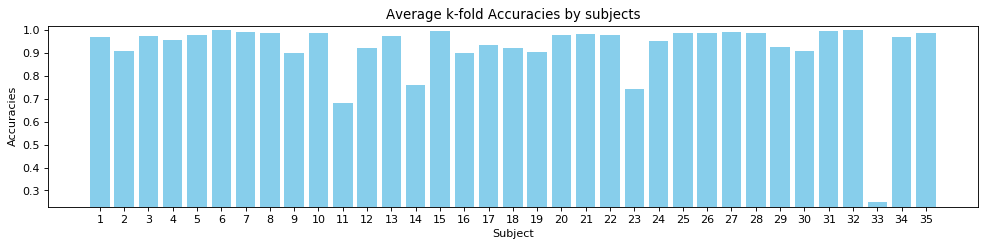

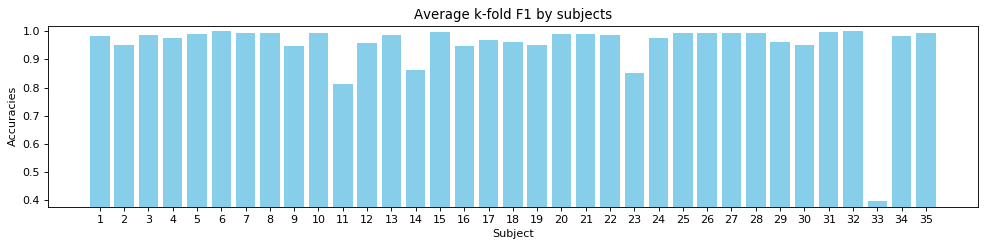

Average acc: 0.9224380952380953
Average f1: 0.9521142857142857


In [9]:
# acc
subjects = []
acc = []
acc_min = 1.0
acc_max = 0.0

for subject_id in subject_kfold_acc:
    subjects.append(subject_id)
    avg_acc = np.mean(subject_kfold_acc[subject_id])
    if avg_acc < acc_min:
        acc_min = avg_acc
    if avg_acc > acc_max:
        acc_max = avg_acc
    acc.append(avg_acc)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, acc, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold Accuracies by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([acc_min-0.02, acc_max+0.02])
plt.show()

# f1
subjects = []
f1 = []
f1_min = 1.0
f1_max = 0.0

for subject_id in subject_kfold_f1:
    subjects.append(subject_id)
    avg_f1 = np.mean(subject_kfold_f1[subject_id])
    if avg_f1 < f1_min:
        f1_min = avg_f1
    if avg_f1 > f1_max:
        f1_max = avg_f1
    f1.append(avg_f1)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, f1, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold F1 by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([f1_min-0.02, f1_max+0.02])
plt.show()


print('Average acc:', np.mean(acc))
print('Average f1:', np.mean(f1))

In [10]:
cca_based_acc = {
  1:	{"itcca": 0.92, "trca": 0.93, "cca": 0.51, "fbcca": 0.78},
  2:	{"itcca": 0.94, "trca": 0.98, "cca": 0.7, "fbcca": 0.88},
  3:	{"itcca": 0.99, "trca": 0.99, "cca": 0.95, "fbcca": 0.98},
  4:	{"itcca": 0.97, "trca": 0.96, "cca": 0.84, "fbcca": 0.88},
  5:	{"itcca": 0.99, "trca": 0.98, "cca": 0.71, "fbcca": 0.89},
  6:	{"itcca": 0.88, "trca": 0.9, "cca": 0.56, "fbcca": 0.74},
  7:	{"itcca": 0.89, "trca": 0.95, "cca": 0.48, "fbcca": 0.68},
  8:	{"itcca": 0.81, "trca": 0.86, "cca": 0.37, "fbcca": 0.48},
  9:	{"itcca": 0.8, "trca": 0.78, "cca": .56, "fbcca": 0.73},
  10:	{"itcca": 0.91, "trca": 0.9, "cca": 0.66, "fbcca": 0.76},
  11:	{"itcca": 0.54, "trca": 0.54, "cca": 0.2, "fbcca": 0.28},
  12:	{"itcca": 0.99, "trca": 0.98, "cca": 0.9, "fbcca": 0.93},
  13:	{"itcca": 0.96, "trca": 0.95, "cca": 0.49, "fbcca": 0.68},
  14:	{"itcca": 0.99, "trca": 0.99, "cca": 0.83, "fbcca": 0.88},
  15:	{"itcca": 0.78, "trca": 0.83, "cca": 0.41, "fbcca": 0.46},
  16:	{"itcca": 0.55, "trca": 0.74, "cca": 0.18, "fbcca": 0.55},
  17:	{"itcca": 0.9, "trca": 0.92, "cca": 0.48, "fbcca": 0.54},
  18:	{"itcca": 0.76, "trca": 0.78, "cca": 0.46, "fbcca": 0.65},
  19:	{"itcca": 0.32, "trca": 0.37, "cca": 0.15, "fbcca": 0.25},
  20:	{"itcca": 0.95, "trca": 0.95, "cca": .63, "fbcca": 0.87},
  21:	{"itcca": 0.83, "trca": 0.95, "cca": 0.39, "fbcca": 0.57},
  22:	{"itcca": 0.93, "trca": 0.95, "cca": 0.68, "fbcca": 0.94},
  23:	{"itcca": 0.89, "trca": 0.88, "cca": 0.62, "fbcca": 0.9},
  24:	{"itcca": 0.95, "trca": 0.96, "cca": 0.66, "fbcca": 0.84},
  25:	{"itcca": 0.97, "trca": 0.98, "cca": 0.86, "fbcca": 0.8},
  26:	{"itcca": 0.99, "trca": 1,	"cca": 0.87, "fbcca": 0.83},
  27:	{"itcca": 0.98, "trca": 1, "cca": 0.79, "fbcca": 0.88},
  28:	{"itcca": 0.92, "trca": 0.95, "cca": .58, "fbcca": 0.9},
  29:	{"itcca": 0.6, "trca": 0.52, "cca": 0.15, "fbcca": 0.4},
  30:	{"itcca": 0.88, "trca": 0.86, "cca": 0.6, "fbcca": 0.72},
  31:	{"itcca": 1, "trca": 1, "cca": 0.9, "fbcca": 0.98},
  32:	{"itcca": 1, "trca": 1, "cca": 0.86, "fbcca": 0.92},
  33:	{"itcca": 0.36, "trca": 0.42, "cca": 0.2, "fbcca": 0.26},
  34:	{"itcca": 0.97, "trca": 0.98, "cca": 0.8, "fbcca": 0.86},
  35:	{"itcca": 0.94, "trca": 0.93, "cca": 0.63, "fbcca": 0.57}
}

fbcca = []
trca = []
cca = []
subjects_id = list(cca_based_acc.keys())

for subject in cca_based_acc:
    fbcca.append(cca_based_acc[subject]["fbcca"])
    trca.append(cca_based_acc[subject]["trca"])
    cca.append(cca_based_acc[subject]["cca"])
 

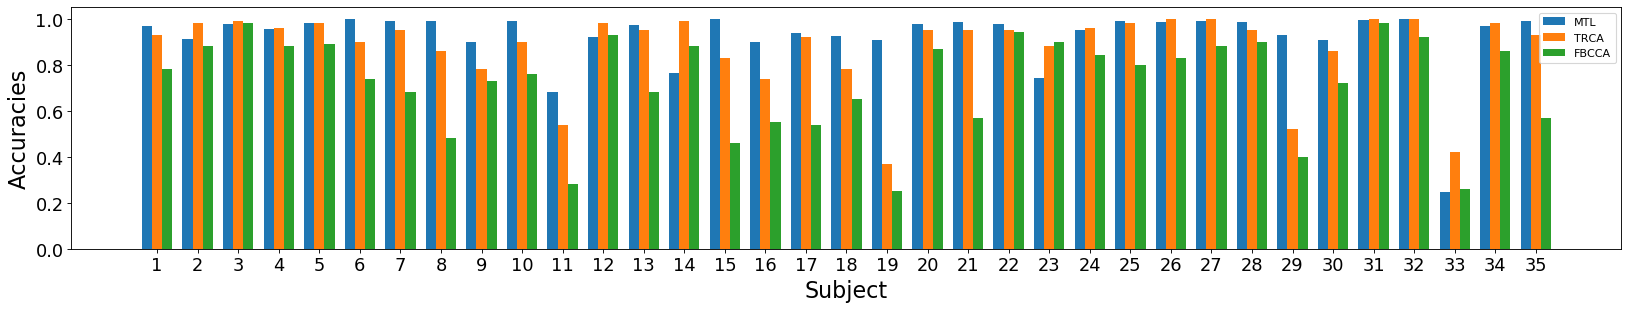

In [11]:
ind = np.arange(len(subjects_id))  # the x locations for the groups
bar_width = 0.25
width = 0.25

plt.rcParams.update({'font.size': 10})
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

fig, ax = plt.subplots(figsize=(25, 4), dpi=80, facecolor='w', edgecolor='k')

rects1 = ax.bar(ind - bar_width, acc, width, label='MTL')
rects2 = ax.bar(ind, trca, width, label='TRCA')
rects3 = ax.bar(ind + bar_width, fbcca, width, label='FBCCA')
# rects4 = ax.bar(ind + bar_width*1.5, cca, width, label='CCA')

ax.set_xlabel("Subject", fontsize=20)
ax.set_ylabel('Accuracies', fontsize=20)
# ax.set_title('Compare Accuracies by Methods')
ax.set_xticks(ind)
ax.set_xticklabels(subjects_id)
ax.legend()

plt.show()